Description Dataset Similarity Matrix
=====================

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import csv
import multiprocessing as mp
from functools import partial
import numpy as np
from collections import Counter, defaultdict
from math import log, sqrt, acos, pi

In [2]:
# Load files
catDescFile = 'cat_desc.csv'
catDescHeaders = None
catDescCnt = Counter()
with open(catDescFile) as fin:
    r = csv.reader(fin)
    for row in r:
        if catDescHeaders is None:
            catDescHeaders = row
            print catDescHeaders
        else:
            catDescCnt[int(row[0]), row[1]] += int(row[-1])

catNameFile = 'categoryKey.csv'
catName = {}
with open(catNameFile) as fin:
    r = csv.reader(fin)
    for row in r:
        catName[int(row[0])] = row[1]

['category_id', 'description', 'count']


In [3]:
# Intermediate information
catList = set()
descList = set()
catOccur = Counter()
for (c, d), v in catDescCnt.iteritems():
    catList.add(c)
    descList.add(d)
    catOccur[c] += v
catList = sorted(catList)
descList = sorted(descList)

def mp_kernel(descList, catDescCnt, catOccur, c):
    tmp = []
    for i, d in enumerate(descList):
        if catDescCnt[c, d] > 0:
            tmp.append((i, float(catDescCnt[c, d]) / catOccur[c]))
    return tuple(tmp)

mpPool = mp.Pool()
catDescDist = tuple(mpPool.map(partial(mp_kernel, descList, catDescCnt, catOccur), catList))

In [4]:
# Computing similarity matrix with parallelization
def sparseVec2Itr(lst1, lst2):
        i1 = i2 = 0
        while i1 < len(lst1) or i2 < len(lst2):
            if i1 == len(lst1):
                yield (0, lst2[i2][1])
                i2 += 1
            elif i2 == len(lst2):
                yield (lst1[i1][1], 0)
                i1 += 1
            elif lst1[i1][0] < lst2[i2][0]:
                yield (lst1[i1][1], 0)
                i1 += 1
            elif lst1[i1][0] > lst2[i2][0]:
                yield (0, lst2[i2][1])
                i2 += 1
            else:
                yield (lst1[i1][1], lst2[i2][1])
                i1 += 1
                i2 += 1

def mp_kernel(catDescDist, metricFn, (cat1, cat2)):
        return metricFn(sparseVec2Itr(catDescDist[cat1], catDescDist[cat2]))

def simMtx_mp(metricFn, halfMatrix=False):
    numCat = len(catDescDist)
    entries = None
    if halfMatrix:
        entries = [(x, y) for x in xrange(numCat) for y in xrange(x+1)]
    else:
        entries = [(x, y) for x in xrange(numCat) for y in xrange(numCat)]

    mpPool = mp.Pool()
    ans = mpPool.map(partial(mp_kernel, catDescDist, metricFn), entries)
    mpPool.close()

    simMtx = np.zeros((numCat, numCat))
    for (x, y), v in zip(entries, ans):
        simMtx[x, y] = v
    if halfMatrix:
        for x in xrange(numCat):
            for y in xrange(x+1, numCat):
                simMtx[x, y] = simMtx[y, x]
    return simMtx

In [5]:
from random import random
def checkMetricFnSym(metricFn, size=1000, threshold=1e-9):
    s1 = []
    s2 = []
    for i in xrange(size):
        if random() * 3 < 1:
            s1.append(0)
            s2.append(random())
        elif random() * 2 < 1:
            s1.append(random())
            s2.append(0)
        else:
            s1.append(random())
            s2.append(random())
    s1 = [float(x) / sum(s1) for x in s1]
    s2 = [float(x) / sum(s2) for x in s2]
    ans1 = metricFn(zip(s1, s2))
    ans2 = metricFn(zip(s2, s1))
    print metricFn.__name__, abs(ans1 - ans2),
    if abs(ans1 - ans2) < threshold:
        print 'ok'
    else:
        print 'ERROR'

In [6]:
def stat_simMtx(mtx, printNum=10):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(1,1,1)
    simMap = ax.pcolormesh(mtx)
    ax.autoscale(tight=True)
    ax.set_frame_on(False)
    ax.axis('off')
    cbar = fig.colorbar(simMap, ax=ax)
    plt.show()

    values = np.concatenate(mtx)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    n, bins, patches = ax.hist(values, 50)
    ax.set_yscale('log')
    plt.show()
    
    entries = []
    for x in xrange(len(catName)):
        for y in xrange(x):
            entries.append((x, y, mtx[x, y]))
    entries.sort(key=lambda x: x[2])
    
    print 'Smallest pairs:'
    for x, y, v in entries[:printNum]:
        print catName[catList[x]], '&' , catName[catList[y]], '-->', v
    print

    print 'Biggest pairs:'
    for x, y, v in entries[-printNum:]:
        print catName[catList[x]], '&' , catName[catList[y]], '-->', v

In [7]:
def store_simMtx(mtx, filename):
    if not all(i+1 == v for i, v in enumerate(catList)):
        raise RuntimeError('Category ordering not understood!')
    np.savetxt(filename, mtx, delimiter=',')

In [8]:
def JensenShannonDiv(itr):
    ans = 0.0
    for x, y in itr:
        if x + y == 0: continue
        m = (x + y) * 0.5
        if x > 0:
            ans += 0.5 * x * log(x / m)
        if y > 0:
            ans += 0.5 * y * log(y / m)
    return ans
checkMetricFnSym(JensenShannonDiv)

def L1Dist(itr):
    ans = 0.0
    for x, y in itr:
        ans += abs(x - y)
    return ans
checkMetricFnSym(L1Dist)

def L2Dist(itr):
    ans = 0.0
    for x, y in itr:
        diff = x - y
        ans += diff * diff
    return ans
checkMetricFnSym(L2Dist)

def InnerProd(itr):
    ans = 0.0
    for x, y in itr:
        ans += x * y
    return 1 - ans
checkMetricFnSym(InnerProd)

def CosSim(itr):
    prod = xSqr = ySqr = 0.0
    for x, y in itr:
        prod += x * y
        xSqr += x * x
        ySqr += y * y
    return 1 - prod / sqrt(xSqr * ySqr)
checkMetricFnSym(CosSim)

def AngularDist(itr):
    prod = xSqr = ySqr = 0.0
    for x, y in itr:
        prod += x * y
        xSqr += x * x
        ySqr += y * y
    cosSim = prod / sqrt(xSqr * ySqr)
    return acos(cosSim) * 2.0 / pi
checkMetricFnSym(AngularDist)

JensenShannonDiv 0.0 ok
L1Dist 0.0 ok
L2Dist 0.0 ok
InnerProd 0.0 ok
CosSim 0.0 ok
AngularDist 0.0 ok


In [9]:
jsdSimMtx = simMtx_mp(JensenShannonDiv, halfMatrix=True)
store_simMtx(jsdSimMtx, 'jsd_sim.csv')

l1SimMtx = simMtx_mp(L1Dist, halfMatrix=True)
store_simMtx(l1SimMtx, 'l1_sim.csv')

l2SimMtx = simMtx_mp(L2Dist, halfMatrix=True)
store_simMtx(l2SimMtx, 'l2_sim.csv')

ipSimMtx = simMtx_mp(InnerProd, halfMatrix=True)
store_simMtx(ipSimMtx, 'innerProd_sim.csv')

csSimMtx = simMtx_mp(CosSim, halfMatrix=True)
store_simMtx(csSimMtx, 'cosine_sim.csv')

adSimMtx = simMtx_mp(AngularDist, halfMatrix=True)
store_simMtx(adSimMtx, 'angular_sim.csv')

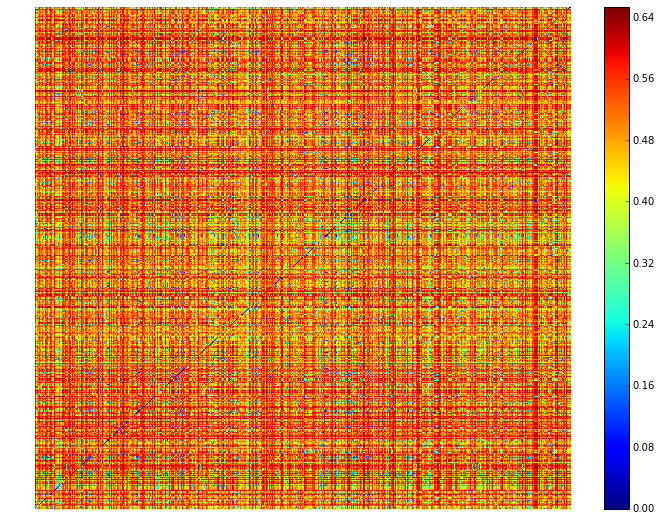

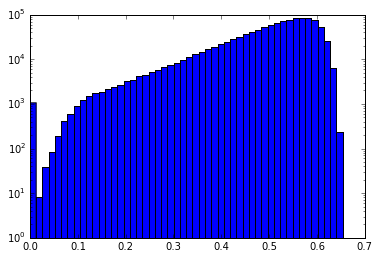

Smallest pairs:
motel room & hotel room --> 0.0223322494639
waterfall (cataract) & cataract --> 0.0225815658049
suvic & guest room --> 0.0253361763504
waterfall (cascade) & cascade --> 0.0254002028128
waterfall (cataract) & waterfall --> 0.0299291111572
waterfall (cascade) & waterfall --> 0.0309745578149
underwater ocean deep & ocean deep --> 0.031507702981
waterfall & cascade --> 0.0328314711791
suvic & master bedroom --> 0.0334239584099
free standing & carport (freestanding) --> 0.033429157066

Biggest pairs:
waterfall (cataract) & bookstore --> 0.646631077956
wave & ball pit --> 0.646736762473
wave & motel room --> 0.646816961717
wave & hotel room --> 0.646967385412
wave & boxing ring --> 0.647025566494
wave & banquet hall --> 0.647384201402
wave & arena (hockey) --> 0.648945081642
wave & batters box --> 0.650234495555
wave & badminton court --> 0.652716686585
wave & stadium --> 0.653589039889


In [10]:
stat_simMtx(jsdSimMtx)

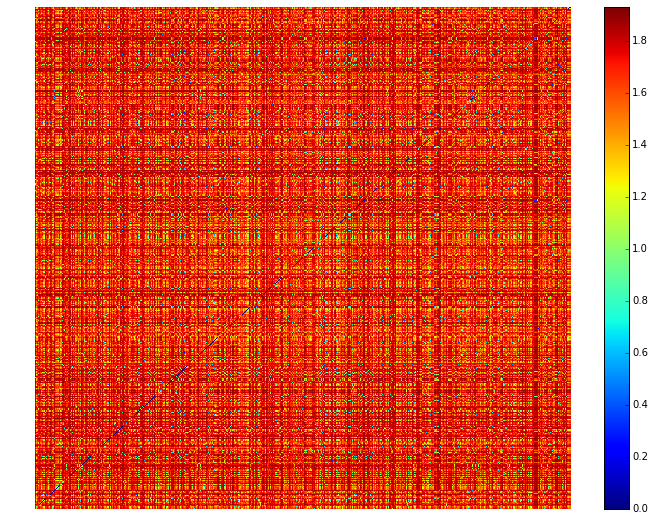

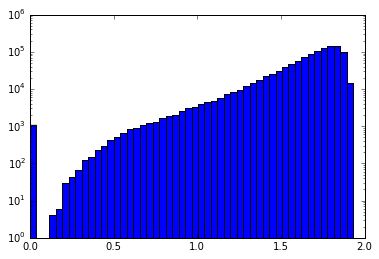

Smallest pairs:
motel room & hotel room --> 0.121234652234
suvic & guest room --> 0.149966996209
suvic & master bedroom --> 0.174360799996
underwater ocean deep & ocean deep --> 0.185073100623
free standing & carport (freestanding) --> 0.187302655845
waterfall & cascade --> 0.201653386435
master bedroom & guest room --> 0.205080307125
suvic & bed sitting room --> 0.206902192093
underwater ocean shallow & ocean shallow --> 0.20946359444
waterfall (cascade) & cascade --> 0.211567131533

Biggest pairs:
motel room & gorge --> 1.92437205793
wave & convenience store --> 1.92514780145
hotel room & forest road --> 1.92539314282
wave & banquet hall --> 1.92585054271
wave & bookstore --> 1.92605791231
stadium & hotel room --> 1.92610581139
wave & stadium --> 1.92728926285
wave & hotel room --> 1.92811550126
wave & badminton court --> 1.92829590516
wave & motel room --> 1.9303541085


In [11]:
stat_simMtx(l1SimMtx)

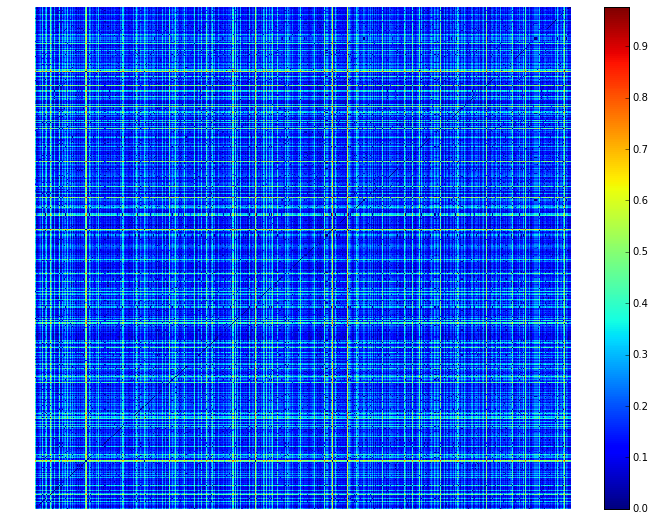

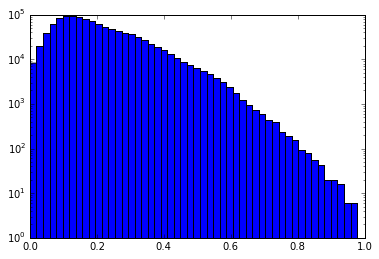

Smallest pairs:
free standing & carport (freestanding) --> 0.000341066909329
western & temple (western) --> 0.0003916263134
urban & flight of stairs (urban) --> 0.000419680149666
underwater ocean shallow & ocean shallow --> 0.000427497544975
motel room & hotel room --> 0.000443864074332
underwater ocean deep & ocean deep --> 0.000496965877286
freight elevator & freight elevator --> 0.000568419967787
natural & flight of stairs (natural) --> 0.000591545864912
underwater ice & ice --> 0.000649939089049
theater (indoor, round) & indoor (round) --> 0.000687811648966

Biggest pairs:
master bedroom & forest --> 0.926587801618
master bedroom & chemical plant --> 0.931174575449
suvic & forest --> 0.93145511491
suvic & chemical plant --> 0.937750030016
oil refinery & hotel room --> 0.939567271973
office cubicles & hotel room --> 0.941180860988
motel room & forest --> 0.955255877853
motel room & chemical plant --> 0.963881971403
hotel room & forest --> 0.970440740298
hotel room & chemical plant -

In [12]:
stat_simMtx(l2SimMtx)

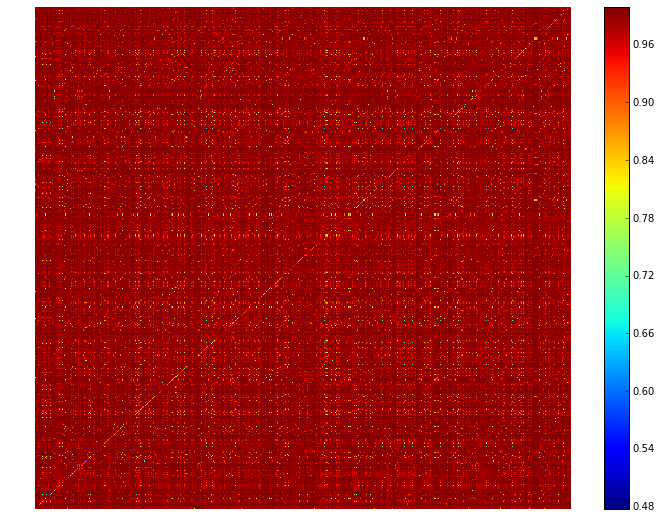

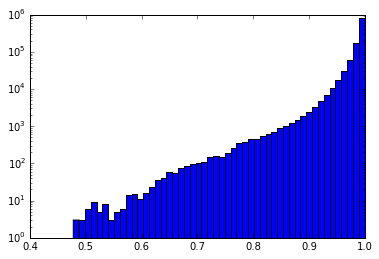

Smallest pairs:
motel room & hotel room --> 0.485278402332
suvic & hotel room --> 0.497764336074
master bedroom & hotel room --> 0.501222871348
suvic & motel room --> 0.504890612377
motel room & master bedroom --> 0.508483564403
hotel room & bed sitting room --> 0.510365598423
suvic & master bedroom --> 0.517582003143
motel room & bed sitting room --> 0.5176162921
hotel room & guest room --> 0.519365399217
motel room & guest room --> 0.526237562969

Biggest pairs:
bus depot & ball pit --> 0.999535328626
train railway & ball pit --> 0.999538592585
pig farm & ball pit --> 0.999541810766
swimming pool & railway yard --> 0.9995425946
veterinarian's office & train railway --> 0.99955702164
railway yard & aquatic theater --> 0.999564117792
railroad track & bookstore --> 0.999565446288
railway yard & ball pit --> 0.99957276965
cataract & boxing ring --> 0.999587303536
waterfall (cataract) & bookstore --> 0.999618465024


In [13]:
stat_simMtx(ipSimMtx)

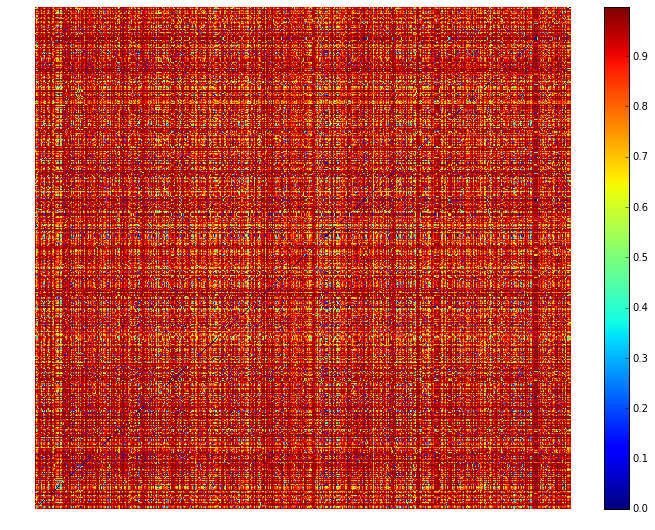

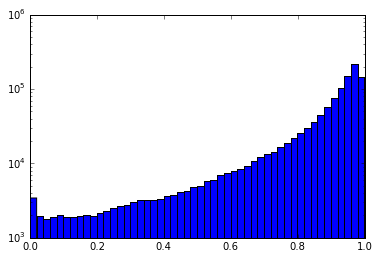

Smallest pairs:
motel room & hotel room --> 0.000328022683111
suvic & guest room --> 0.000348446926972
state room & guest room --> 0.000351984079858
oil refinery & chemical plant --> 0.000366538642978
rolling mil & particle accelerator --> 0.000676528094483
suvic & state room --> 0.000826508419398
semi detached house & duplex house --> 0.000870504315992
master bedroom & guest room --> 0.000897643583438
power plant (indoor) & nuclear power plant (indoor) --> 0.000988799647838
suvic & master bedroom --> 0.00105878266359

Biggest pairs:
circus tent (indoor) & cataract --> 0.997959326291
hotel room & cataract --> 0.997976672658
swimming pool & catwalk --> 0.99803913791
train railway & shower --> 0.998072011636
circus tent (indoor) & arrival gate --> 0.998080060936
circus tent (indoor) & car interior --> 0.998085313242
train railway & men's room --> 0.998159867321
train railway & swimming pool --> 0.998428508046
waterfall (cataract) & bookstore --> 0.998500868737
train railway & circus tent

In [14]:
stat_simMtx(csSimMtx)

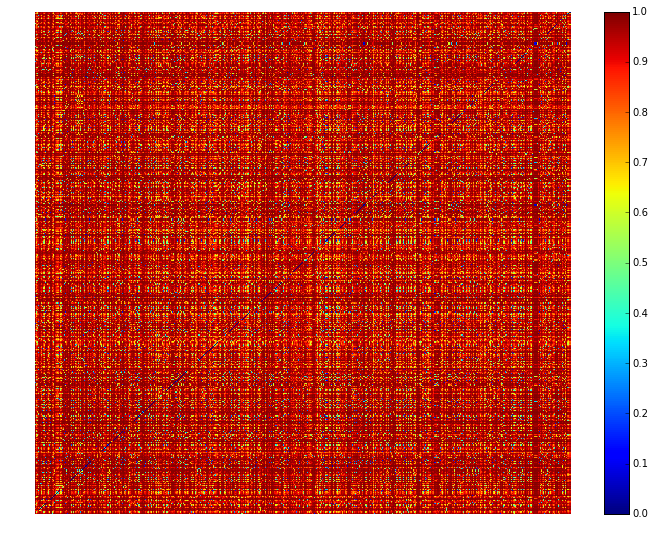

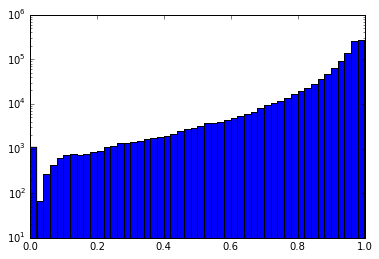

Smallest pairs:
motel room & hotel room --> 0.0163064315363
suvic & guest room --> 0.016806452473
state room & guest room --> 0.0168915448557
oil refinery & chemical plant --> 0.0172372615317
rolling mil & particle accelerator --> 0.0234186861541
suvic & state room --> 0.0258850303576
semi detached house & duplex house --> 0.0265651391298
master bedroom & guest room --> 0.0269761258075
power plant (indoor) & nuclear power plant (indoor) --> 0.0283129462633
suvic & master bedroom --> 0.0292979246454

Biggest pairs:
circus tent (indoor) & cataract --> 0.998700865866
hotel room & cataract --> 0.998711908929
swimming pool & catwalk --> 0.998751675623
train railway & shower --> 0.998772603726
circus tent (indoor) & arrival gate --> 0.998777728079
circus tent (indoor) & car interior --> 0.998781071807
train railway & men's room --> 0.998828534492
train railway & swimming pool --> 0.998999556738
waterfall (cataract) & bookstore --> 0.999045623039
train railway & circus tent (indoor) --> 0.999

In [15]:
stat_simMtx(adSimMtx)